###########################################################################################################################
###               LAPLACE EQUATION SOLUTION WITH PINN FOR A 2D RECTANGULAR PLATE
###                                  AUTHOR: Sanjay R
###
###########################################################################################################################

In [16]:
import os
import scipy.io
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.animation as animation
from matplotlib.image import imread

In [17]:
def set_boundary_conditions(Lx, Ly, num_points_per_edge, random = False):
    if random:
        x_boundary_top = np.random.uniform(0, Lx, num_points_per_edge)
        y_internal_right = np.random.uniform(0, Ly, num_points_per_edge)
        x_boundary_bottom = np.random.uniform(Lx, 0, num_points_per_edge)
        y_boundary_left = np.random.uniform(Ly, 0, num_points_per_edge)
    else: 
        x_boundary_top = np.linspace(0, Lx, num_points_per_edge)
        y_internal_right = np.linspace(0, Ly, num_points_per_edge)
        x_boundary_bottom = np.linspace(Lx, 0, num_points_per_edge)
        y_boundary_left = np.linspace(Ly, 0, num_points_per_edge)

    y_boundary_top = np.ones_like(x_boundary_top) * Ly

    x_boundary_right = np.ones(num_points_per_edge) * Lx
    

    
    y_boundary_bottom = np.zeros_like(x_boundary_bottom)

    x_boundary_left = np.zeros(num_points_per_edge)
    

    x_boundary = np.concatenate([x_boundary_top, x_boundary_right, x_boundary_bottom, x_boundary_left])
    y_boundary = np.concatenate([y_boundary_top, y_internal_right, y_boundary_bottom, y_boundary_left])

    T_boundary = np.zeros_like(x_boundary)
    T_boundary[2*num_points_per_edge:3*num_points_per_edge] = np.ones(num_points_per_edge) * 250

    class BoundaryConditions:
        def __init__(self, x, y, T):
            self.x = x
            self.y = y
            self.T = T
            
    boundary_conditions = BoundaryConditions(x_boundary, y_boundary, T_boundary)

    return boundary_conditions

In [18]:
# def set_initial_conditions(Lx, Ly, num_points, random=False):
#     # Randomly generate points or make a mesh
#     if random:
#         x_initial = np.random.uniform(0, Lx, num_points)
#         y_initial = np.random.uniform(0, Ly, num_points)
#     else:
#         x_points = np.linspace(0, Lx, num_points)
#         y_points = np.linspace(0, Ly, num_points)

#         x_grid, y_grid = np.meshgrid(x_points, y_points)

#         x_initial = x_grid.flatten()
#         y_initial = y_grid.flatten()
    
#     T_initial = np.zeros_like(x_initial)

#     class Conditions:
#         def __init__(self, x, y, T):
#             self.x = x
#             self.y = y
#             self.T = T


#     initial_conditions = Conditions(x_initial, y_initial, T_initial)
    
#     return initial_conditions

In [19]:
def set_equation(Lx, Ly, num_points, random=False):
    if random:
        x_equation = np.random.uniform(0, Lx, num_points)
        y_equation = np.random.uniform(0, Ly, num_points)
    else:
        x_points = np.linspace(0, Lx, num_points)
        y_points = np.linspace(0, Ly, num_points)

        x_grid, y_grid = np.meshgrid(x_points, y_points)

        x_equation = x_grid.flatten()
        y_equation = y_grid.flatten()
        
    class Equation:
        def __init__(self, x, y):
            self.x = x
            self.y = y

    equation = Equation(x_equation, y_equation)

    return equation

In [20]:
# Domain size
Lx = 1
Ly = 2

# Number of points per edge
num_points_per_edge = 150

# Generate boundary conditions
boundary_conditions = set_boundary_conditions(Lx, Ly, 
                                              num_points_per_edge, random = True)

# Number of points in equation
num_points_equation = 100

# Generate equation
equation = set_equation(Lx, Ly, num_points_equation, random=False)

In [ ]:
class PINN():
    def __init__(self, boundary_conditions, equation):
        # Set data
        # self.x_initial = torch.tensor(initial_conditions.x,
        #                               dtype=torch.float32, 
        #                               requires_grad=True).view(-1, 1)
        # self.y_initial = torch.tensor(initial_conditions.y, 
        #                               dtype=torch.float32, 
        #                               requires_grad=True).view(-1, 1)
        # self.T_initial = torch.tensor(initial_conditions.T, 
        #                               dtype=torch.float32, 
        #                               requires_grad=True).view(-1, 1)
        
        self.x_boundary = torch.tensor(boundary_conditions.x, 
                                       dtype=torch.float32, 
                                       requires_grad=True).view(-1, 1)
        self.y_boundary = torch.tensor(boundary_conditions.y, 
                                       dtype=torch.float32, 
                                       requires_grad=True).view(-1, 1)
        self.T_boundary = torch.tensor(boundary_conditions.T, 
                                       dtype=torch.float32, 
                                       requires_grad=True).view(-1, 1)
                
        self.x_equation = torch.tensor(equation.x, 
                                       dtype=torch.float32, 
                                       requires_grad=True).view(-1, 1)
        self.y_equation = torch.tensor(equation.y, 
                                       dtype=torch.float32, 
                                       requires_grad=True).view(-1, 1)

        # Initialize network:
        self.network()

        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=0.002)
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=1000, gamma=0.9)
        # Loss pde
        self.mse = nn.MSELoss()

        # Loss
        self.loss = 0

        # Iteration number
        self.iter = 0

    def network(self):
        self.net = nn.Sequential(
            nn.Linear(2, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 64), nn.Tanh(),
            nn.Linear(64, 1))

    def pde(self, x, y, is_equation=False):
        # print(f"x shape: {x.shape}, y shape: {y.shape}")
        model = torch.cat([x.view(-1, 1), y.view(-1, 1)],dim=1)
        # print(f"modelshape:{model.shape}")

        T = self.net(model)
        # print(f"T shape: {T.shape}")

        if is_equation:
            T_x = torch.autograd.grad(T, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]
            T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T), create_graph=True)[0]

            T_y = torch.autograd.grad(T, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]
            T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T), create_graph=True)[0]

            return T, T_xx + T_yy

        return T
    
    def loss_func_solve(self):
        # Reset gradients
        self.optimizer.zero_grad()

        # Initial loss
        # T_prediction = self.pde(self.x_initial, self.y_initial)

        # initial_loss = self.mse(T_prediction, self.T_initial)

        # Boundary loss
        T_prediction = self.pde(self.x_boundary, self.y_boundary)

        boundary_loss = (self.mse(T_prediction, self.T_boundary)) *10

        # Equation loss
        T_prediction, residual = self.pde(self.x_equation, self.y_equation, is_equation=True)
        equation_loss = self.mse(residual, torch.zeros_like(residual))

        self.loss = boundary_loss + equation_loss

        # Derivative with respect to weights
        self.loss.backward()

        self.iter += 1
        if not self.iter % 100:
            print('Iteration: {:}, boundary Loss: {:0.6f}, equation Loss: {:0.6f}'.format(self.iter, boundary_loss, equation_loss))

        return self.loss

    def train(self):
        # Training loop
        for _ in range(50                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     000):
            self.net.train()
            self.optimizer.step(self.loss_func_solve)
            self.scheduler.step()

In [22]:
# Create model
pinn = PINN(boundary_conditions, equation)

# Train model
pinn.train()

# Save model
torch.save(pinn.net.state_dict(), 'model.pt')

Iteration: 100, boundary Loss: 136046.562500, equation Loss: 110.120354
Iteration: 200, boundary Loss: 122224.695312, equation Loss: 428.639740
Iteration: 300, boundary Loss: 109938.132812, equation Loss: 211.636429
Iteration: 400, boundary Loss: 98677.531250, equation Loss: 431.982605
Iteration: 500, boundary Loss: 93860.218750, equation Loss: 222.639572
Iteration: 600, boundary Loss: 83010.671875, equation Loss: 311.402557
Iteration: 700, boundary Loss: 74421.781250, equation Loss: 223.297623
Iteration: 800, boundary Loss: 66445.554688, equation Loss: 183.877350
Iteration: 900, boundary Loss: 59527.750000, equation Loss: 428.435791
Iteration: 1000, boundary Loss: 52922.046875, equation Loss: 874.933899
Iteration: 1100, boundary Loss: 47877.738281, equation Loss: 956.013000
Iteration: 1200, boundary Loss: 43157.867188, equation Loss: 626.835388
Iteration: 1300, boundary Loss: 38991.773438, equation Loss: 1375.140747
Iteration: 1400, boundary Loss: 35120.773438, equation Loss: 737.2753

In [23]:
def visualize_points(x_test, y_test, T_test, name, title="PINN", ifshow=False):
    # Create a directory to save the images
    save_path="PINN_Solution_laplace"
    os.makedirs(save_path, exist_ok=True)
    
    # Create a figure and axis
    
    plt.contourf(x_test,y_test, T_test, cmap='plasma', levels=256)
    plt.title(title)
    plt.colorbar(label=name)
    plt.xlabel('x')
    plt.ylabel('y')

    # Save the plot to the images directory
    num = str(len(os.listdir(save_path)))
    plt.savefig(os.path.join(save_path, f'{name}_{num}.png'))
    if ifshow:
        plt.show()
    plt.clf()

/tmp/ipykernel_62953/3095600075.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pinn.net.load_state_dict(torch.load('model.pt'))


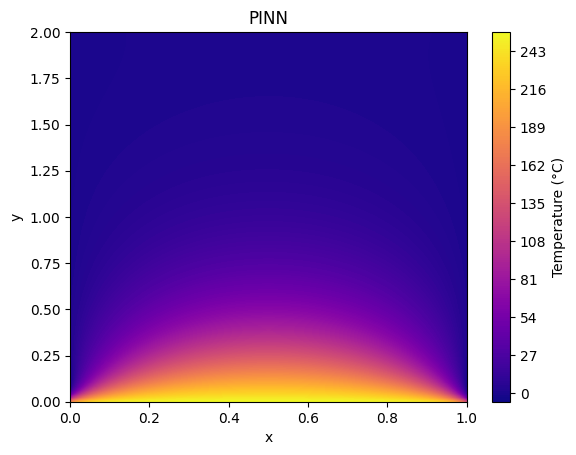

<Figure size 640x480 with 0 Axes>

In [24]:
pinn = PINN(boundary_conditions, equation)
pinn.net.load_state_dict(torch.load('model.pt'))
pinn.net.eval()
x_points = np.linspace(0, Lx, num_points_equation)
y_points = np.linspace(0, Ly, num_points_equation)

x_grid, y_grid = np.meshgrid(x_points, y_points)

x_test = x_grid.flatten()
y_test = y_grid.flatten()

class Test:
    def __init__(self, x, y):
        self.x = x
        self.y = y

test = Test(x_test, y_test)
x_test = torch.tensor(test.x[:, np.newaxis], dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(test.y[:, np.newaxis], dtype=torch.float32, requires_grad=True)
T_test = pinn.pde(x_test, y_test)
T_PINN = T_test.to('cpu').detach().numpy().reshape(-1, num_points_equation)
visualize_points(x_grid, y_grid, T_PINN, 'Temperature (°C)', ifshow=True)


In [25]:
# from PIL import Image

# folder_path = 'save_images_PINN_flat_plate'

# image_files = sorted(
#     [img for img in os.listdir(folder_path) if img.endswith(".png")],
#     key=lambda x: int(x.split('_')[1].split('.')[0]),
# )

# images = [Image.open(os.path.join(folder_path, img)) for img in image_files]

# images[0].save('output.gif', save_all=True, append_images=images[1:], optimize=False, duration=500, loop=0)
# print("GIF image has been created and saved as 'output.gif'")

## FDM Solution with PSOR Scheme

In [26]:
num_pts = 100
x = np.linspace(0, Lx, num_pts)
y = np.linspace(0, Ly, num_pts)
X, Y = np.meshgrid(x, y)

# Grid spacing
dx=Lx/(num_pts-1)
dy=Ly/(num_pts-1)
beta=dx/dy

# Initialization for the temperature field and boundary conditions
T_FDM=np.zeros((num_pts, num_pts))

T_FDM[:,0] =250  # Bottom boundary
T_FDM[:,-1] =0  # Top boundary
T_FDM[0,:] =0  # Left boundary
T_FDM[-1,:] =0  # Right boundary

In [27]:
##### SIMULATION PART, FDM SOLUTION WITH POINT-SUCCESSIVE OVER RELAXATION (PSOR) METHOD #####
tolerance=1e-3
error=1
iterations=0
errors=[]
a=((np.cos(np.pi/(num_pts-1))+ beta**2*np.cos(np.pi/(num_pts-1)))/(1+beta**2))**2 # For PSOR scheme
w= (2-2*(1-a)**(0.5))/a
while error > tolerance: ###Simulation run without calling function as similar to executions in CFD softwares, it may increase time very slightly
    T_old=T_FDM.copy()
    for i in range(1,num_pts-1):
        for j in range(1,num_pts-1):
            T_FDM[i,j] = (1-w)*T_old[i,j] + w/(2*(1+beta**2)) *(T_old[i+1, j] + T_FDM[i-1, j] + beta**2*T_old[i,j+1] + beta**2 * T_FDM[i,j-1])
    error = np.sum(np.abs(T_FDM-T_old))
    errors.append(error)
    iterations += 1
print("The total no. of iterations:",iterations)

The total no. of iterations: 290


In [28]:
##### COMPUTING EXACT SOLUTION #####
def exact_solution(x, y):
    T_exact=np.zeros((num_pts, num_pts))
    for i in range(num_pts):
        for j in range(num_pts):
            for n in range(1,90):  # Using a finite number of terms for approximation
                T_exact[i,j] += 250*(2 * (1 - (-1)**n) / (n * np.pi) * np.sinh(n * np.pi * (Ly - y[j]) / Lx) * np.sin(n * np.pi * x[i] / Lx) / np.sinh(n * np.pi * Ly / Lx))
    return T_exact

T_exact = exact_solution(x, y)

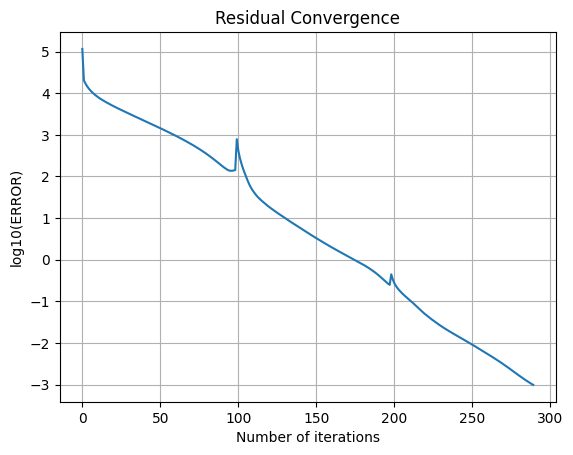

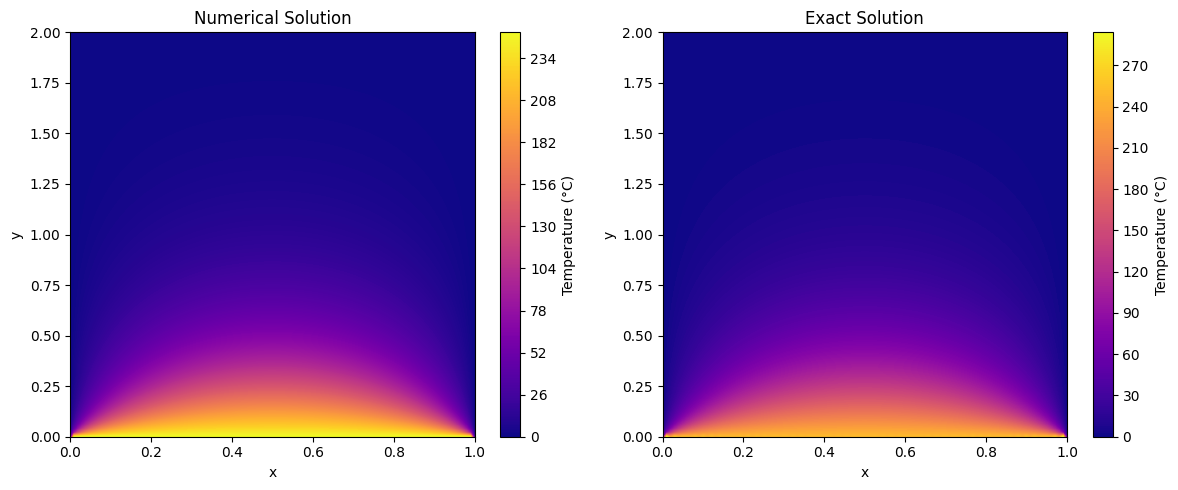

In [29]:
# Plot convergence
plt.figure()
plt.plot(range(iterations), np.log10(errors))
plt.xlabel('Number of iterations')
plt.ylabel('log10(ERROR)')
plt.title('Residual Convergence')
plt.grid(True)
plt.show()

##### POST-PROCESSING RESULTS WITH PLOTS #####

plt.figure(figsize=(12,5))
# Plotting numerical solution
plt.subplot(1,2,1)
plt.contourf(x,y, T_FDM.T, cmap='plasma', levels=256) #convention for 2D arrays is that the first index corresponds to the row number (y-coordinate) and the second index corresponds to the column number (x-coordinate)
plt.colorbar(label='Temperature (°C)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Numerical Solution')
# Plotting exact solution
plt.subplot(1,2,2)
plt.contourf(x,y, T_exact.T, cmap='plasma', levels=256)
plt.colorbar(label='Temperature (°C)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Exact Solution')
plt.tight_layout()
plt.show()

In [ ]:
# Compute NRMSE
def calculate_nrmse(predicted, exact):
    n = predicted.size
    error = predicted - exact
    mse = np.sum(error**2) / n
    rmse = np.sqrt(mse)
    normalization = np.max(exact) - np.min(exact)
    return rmse / normalization

nrmse_PINN = calculate_nrmse(T_PINN, T_exact)
nrmse_FDM = calculate_nrmse(T_FDM, T_exact)

# Display results
print(f"NRMSE (PINN): {nrmse_PINN:.6f}")
print(f"NRMSE (FDM): {nrmse_FDM:.6f}")

NRMSE (PINN): 0.120406
NRMSE (FDM): 0.009232


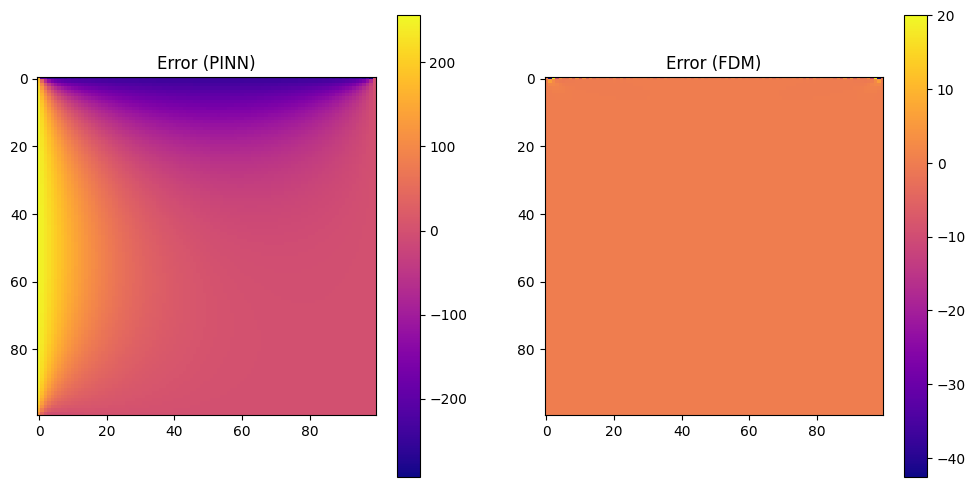

In [31]:
error_PINN = T_PINN.T - T_exact.T
error_FDM = T_FDM.T - T_exact.T

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Error (PINN)")
plt.imshow(error_PINN, cmap='plasma', interpolation='nearest')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Error (FDM)")
plt.imshow(error_FDM, cmap='plasma', interpolation='nearest')
plt.colorbar()

plt.show()